## Adult Dataset Part 1: Cleaning and Preparation

#### Objectives:
1. Preprocess the data and store the cleaned dataset as adult_clean.csv
2. Load clean dataset and test supervised/unsupervised models
    - Goal: Determine best model to predict if new entry earns >50k or <50k with supervised learning
    - Goal: Find insights and patterns in data using unspuervised learning
3. Apply k-folds cross validation
    - Goal: Evaluate robustness of results across different models.
    - Goal: Use and justify different error metrics


#### Summary of dataset

Datasource: https://archive.ics.uci.edu/ml/datasets/adult

Feature descrptions copied below from the UCI website:

- age: continuous. 
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
- fnlwgt: Continuous. A weighting assigned from the sampling process.
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
- education-num: continuous. 
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. 
- sex: Female, Male. 
- capital-gain: continuous.
- capital-loss: continuous. 
- hours-per-week: continuous. 
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
- target: >50K, <=50K.

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [115]:
#original data does not come with headers. add headers based on the documentation descrption
headers = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
           'hours-per-week', 'native-country', 'target']

In [116]:
data = pd.read_csv('./data/adult.data', names = headers)
df = data.copy()

In [117]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


On first look, it appears there are no missing values. **However the dataset descrption indicates that missing values have been flled with '?'.** Figure out what to do here :)

In [119]:
original_df = df.copy()
for c in df.columns:
    df[c] = df[c].apply(lambda x: None if '?' in str(x) else x)
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
target               0
dtype: int64

Before deciding **how to deal with the missing values want to know how they influence the data**. For example, if workclass and occupation for example both have missing values (in the same tuple) it would be reasonable to drop the data.

In [120]:
work_occupy = df.isnull().groupby(['workclass','occupation']).size()
native_work = df.isnull().groupby(['native-country','workclass']).size()

print('Occupation nans in same row as workclass with a nan:',work_occupy.values[-1])
print('Native-country nans in same row as workclass with a nan:',native_work.values[-1])

Occupation nans in same row as workclass with a nan: 1836
Native-country nans in same row as workclass with a nan: 27


**What % of the dataset do nans represent?** What is the **best approach** for dealing with the nan's?

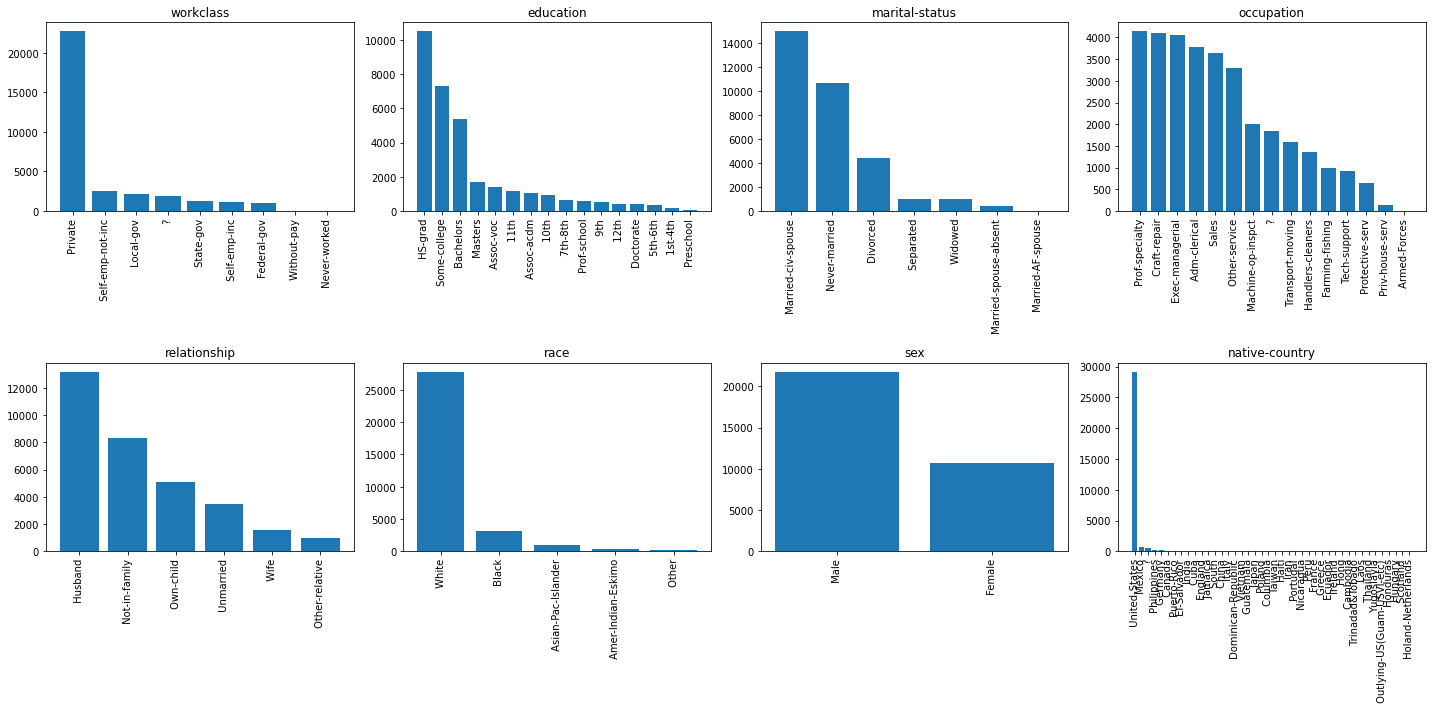

In [122]:
categoricals = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

plt.figure(figsize=(20,10))
for id,c in enumerate(categoricals):
    plt.subplot(2,4,id+1)
    df_c = original_df[c].value_counts()
    plt.bar(x=df_c.index, height=df_c.values)
    plt.title(c)
    plt.xticks(rotation='vertical')
    plt.tight_layout()

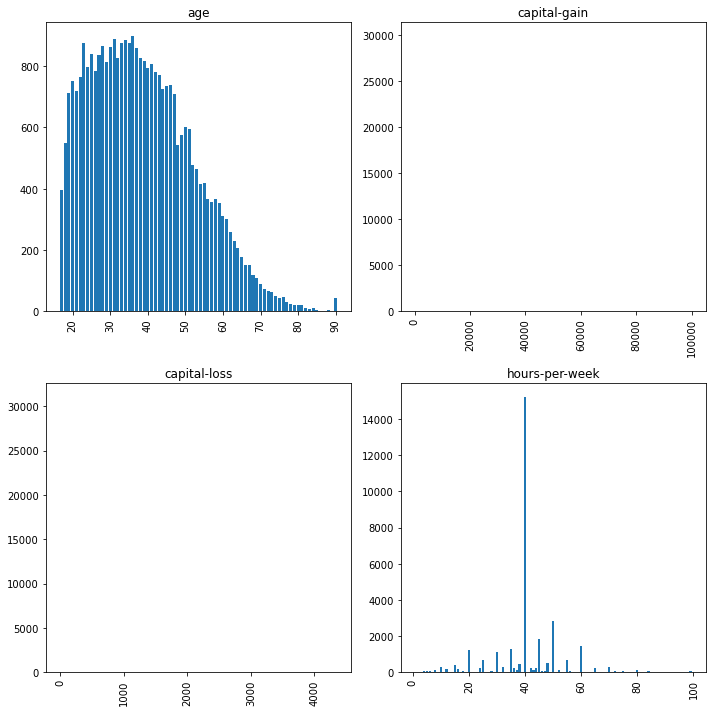

In [155]:
numericals = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
#data.plot(x='month_number',y='bathingsoap',kind='bar',figsize=(10,7))

plt.figure(figsize=(10,10))
for id,c in enumerate(numericals):
    # plt.subplot(2,2,id+1)
    # df_c_key = original_df.groupby([c],as_index=False).sum()[c]
    # df_c_value = original_df.groupby([c],as_index=False)[c].sum()
    # print(df_c_value.values)
    # plt.bar(x=df_c_key, height=[i[0] for i in df_c_value.values])
    # plt.title(c)
    # plt.xticks(rotation='vertical')
    # plt.tight_layout()
    plt.subplot(2,2,id+1)
    df_c = original_df[c].value_counts()
    plt.bar(x=df_c.index, height=df_c.values)
    plt.title(c)
    plt.xticks(rotation='vertical')
    plt.tight_layout()

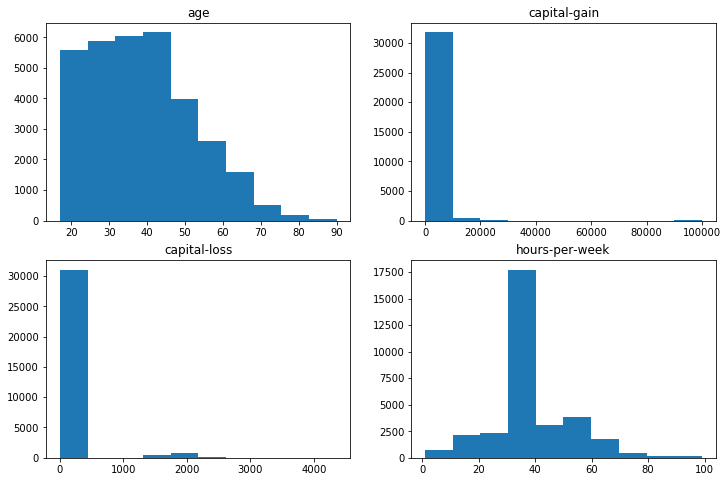

In [81]:
#plot the numerical columns


#### Additional Steps:
1. Apply statistical tests to determine if dropping values changes the structure of the distribution in the workplace, occupation, and native-country categories i.e. t-test for differnce of modes. 
2. Compare filling the workplace and occupation columns with mode values and applying same statistical tests.

In [ ]:
#train / test... you know the drill

# Discussion of results